### SARSA is able to learn?

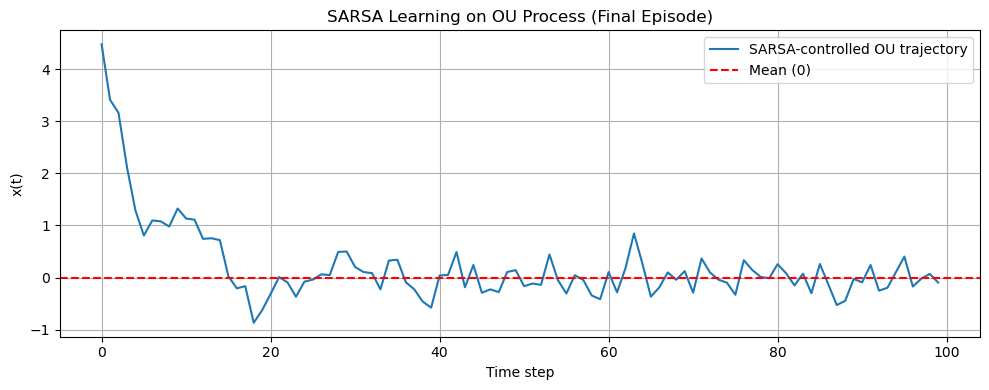

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# OU Process parameters
theta = 0.15
mu = 0.0
sigma = 0.3
dt = 1.0

# Environment: OU process simulator
def ou_step(x):
    return x + theta * (mu - x) * dt + sigma * np.sqrt(dt) * np.random.normal()

# Discretization helper
def discretize(x, bins=100):
    return int(np.clip((x + 10) * bins / 20, 0, bins - 1))  # map from [-10, 10] to [0, bins)

# SARSA agent setup
class SARSA_OU:
    def __init__(self, actions, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.Q = defaultdict(lambda: np.zeros(len(actions)))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actions = actions

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(range(len(self.actions)))
        return np.argmax(self.Q[state])

    def update(self, s, a, r, s_, a_):
        predict = self.Q[s][a]
        target = r + self.gamma * self.Q[s_][a_]
        self.Q[s][a] += self.alpha * (target - predict)

# Actions: move left (-1), stay (0), move right (+1)
actions = [-1, 0, 1]
agent = SARSA_OU(actions)

# Training loop
episodes = 500
steps_per_episode = 100
trajectory = []

for ep in range(episodes):
    x = 5.0  # start far from the mean
    for step in range(steps_per_episode):
        state = discretize(x)
        a_idx = agent.choose_action(state)
        action = actions[a_idx]

        # Apply action as a small push
        x += action * 0.2

        # Simulate OU step
        x = ou_step(x)

        reward = -abs(x)  # penalize being far from mean
        next_state = discretize(x)
        next_a_idx = agent.choose_action(next_state)

        agent.update(state, a_idx, reward, next_state, next_a_idx)

        if ep == episodes - 1:
            trajectory.append(x)

# Plot final trajectory
plt.figure(figsize=(10, 4))
plt.plot(trajectory, label="SARSA-controlled OU trajectory")
plt.axhline(0, color='red', linestyle='--', label="Mean (0)")
plt.title("SARSA Learning on OU Process (Final Episode)")
plt.xlabel("Time step")
plt.ylabel("x(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Portfolio Optimization with SARSA

[*********************100%***********************]  3 of 3 completed


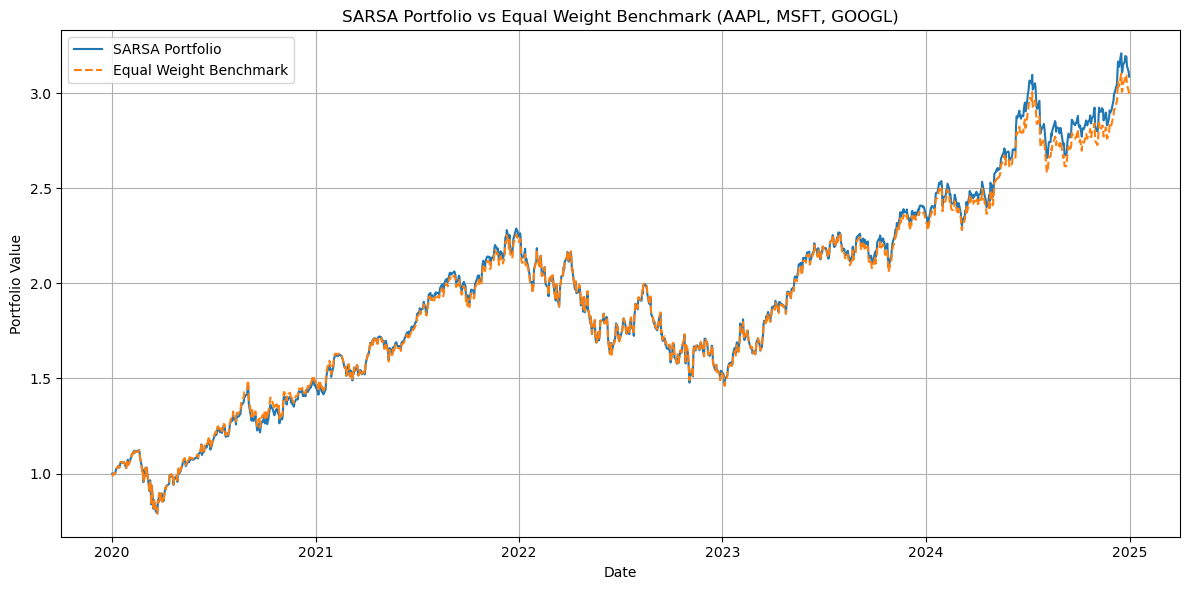

In [11]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# Step 1: Load data
tickers = ["AAPL", "MSFT", "GOOGL"]
data = yf.download(tickers, start="2020-01-01", end="2025-01-01")["Close"].dropna()

# Step 2: Normalize prices
norm_prices = data / data.iloc[0]

# Step 3: Define SARSA Agent
class SARSA_Agent:
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.Q = defaultdict(lambda: np.zeros(len(actions)))
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def get_state(self, prices):
        # Discretize prices to form a state
        return tuple(np.round(prices, 2))

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(range(len(self.actions)))
        return np.argmax(self.Q[state])

    def update(self, s, a, r, s_, a_):
        predict = self.Q[s][a]
        target = r + self.gamma * self.Q[s_][a_]
        self.Q[s][a] += self.alpha * (target - predict)

# Step 4: Define action space (weight combinations)
actions = [
    [1/3, 1/3, 1/3],
    [0.5, 0.25, 0.25],
    [0.25, 0.5, 0.25],
    [0.25, 0.25, 0.5],
    [0.6, 0.2, 0.2],
    [0.2, 0.6, 0.2],
    [0.2, 0.2, 0.6]
]

agent = SARSA_Agent(actions)

# Step 5: SARSA Portfolio Simulation
portfolio_value = [1]
current_weights = actions[0]
prices = norm_prices.values
dates = norm_prices.index

for t in range(len(prices) - 1):
    state = agent.get_state(prices[t])
    action_index = agent.choose_action(state)
    new_weights = actions[action_index]

    # Portfolio return (dot product of weights and price relative change)
    daily_return = np.dot(new_weights, prices[t+1] / prices[t])
    portfolio_value.append(portfolio_value[-1] * daily_return)

    next_state = agent.get_state(prices[t+1])
    next_action_index = agent.choose_action(next_state)

    # Reward is just return here (could be modified to include risk)
    reward = daily_return - 1
    agent.update(state, action_index, reward, next_state, next_action_index)

# Step 6: Benchmark Portfolio (Equal Weights, no rebalancing)
equal_weights = np.array([1/3, 1/3, 1/3])
benchmark = (norm_prices * equal_weights).sum(axis=1)

# Step 7: Plot Results
plt.figure(figsize=(12, 6))
plt.plot(dates, portfolio_value, label="SARSA Portfolio")
plt.plot(dates, benchmark.values, label="Equal Weight Benchmark", linestyle="--")
plt.title("SARSA Portfolio vs Equal Weight Benchmark (AAPL, MSFT, GOOGL)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
# Convert lists to Series
sarsa_series = pd.Series(portfolio_value, index=dates)

# Calculate daily returns
sarsa_returns = sarsa_series.pct_change().dropna()
benchmark_returns = benchmark.pct_change().dropna()

# Calculate Sharpe Ratios
def sharpe_ratio(returns):
    return (returns.mean() / returns.std()) * np.sqrt(252)

sarsa_sharpe = sharpe_ratio(sarsa_returns)
benchmark_sharpe = sharpe_ratio(benchmark_returns)

print(f"Sharpe Ratio (SARSA Portfolio): {sarsa_sharpe:.4f}")
print(f"Sharpe Ratio (Equal-Weight Benchmark): {benchmark_sharpe:.4f}")


Sharpe Ratio (SARSA Portfolio): 0.9368
Sharpe Ratio (Equal-Weight Benchmark): 0.9162
